In [ ]:
!git clone https://github.com/SanjarArani-Ali/diffae.git
%cd diffae

Cloning into 'diffae'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 533 (delta 114), reused 116 (delta 94), pack-reused 374 (from 1)
Receiving objects: 100% (533/533), 14.11 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (305/305), done.
/content/diffae


In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio  pytorch-lightning  torchtext -f https://download.pytorch.org/whl/torch_stable.html
!pip install scipy
!pip install numpy
!pip install tqdm
!pip install pytorch-fid
!pip install pandas
!pip install lpips
!pip install lmdb
!pip install ftfy
!pip install regex
!pip install dlib requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-n

In [ ]:
from templates import *

# load checkpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir checkpoints

In [ ]:
!cp -r /content/drive/MyDrive/ffhq128_autoenc_130M/ checkpoints/

# encode with trained model

## load model

In [ ]:
device = 'cuda:0'
conf = ffhq128_autoenc_130M()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

INFO:lightning_fabric.utilities.seed:Seed set to 0


Model params: 122.59 M


## load EEG

In [ ]:
import lmdb
import numpy as np
from PIL import Image

In [ ]:
!gdown "https://drive.google.com/uc?id=1ZPs9e5_RxZ-JL36udRzWsULv0mpo_Hhv" -O eeg_5_95_std.pth

Downloading...
From (original): https://drive.google.com/uc?id=1ZPs9e5_RxZ-JL36udRzWsULv0mpo_Hhv
From (redirected): https://drive.google.com/uc?id=1ZPs9e5_RxZ-JL36udRzWsULv0mpo_Hhv&confirm=t&uuid=392c8460-0b72-483f-8ad8-cd9e2ae7342f
To: /content/diffae/eeg_5_95_std.pth
100% 3.14G/3.14G [00:25<00:00, 121MB/s]


In [ ]:
%mv eeg_5_95_std.pth datasets

In [ ]:
!sed -i 's/total = 100/total = 300/g' convert_EEG_lmdb.py

In [ ]:
!python convert_EEG_lmdb.py

/bin/bash: line 1: venv/bin/activate: No such file or directory
100% 300/300 [00:03<00:00, 81.46it/s]


In [ ]:
env = lmdb.open(
            'datasets/ffhq256.lmdb',
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
index=200
with env.begin(write=False) as txn:
    # key = f'{self.original_resolution}-{str(index).zfill(self.zfill)}'.encode(
    #     'utf-8')
    key = f'data-{str(index).zfill(5)}'.encode('utf-8')

    img_bytes = txn.get(key)

buffer = np.frombuffer(img_bytes).reshape((128,128,3))
normalized_data = (buffer - np.min(buffer)) / (np.max(buffer) - np.min(buffer))
scaled_data = normalized_data * 255
integer_data = scaled_data.astype(np.uint8)
img = Image.fromarray(integer_data,"RGB")

img.save("imgs_align/EEG1.jpg")

index=201
with env.begin(write=False) as txn:
    # key = f'{self.original_resolution}-{str(index).zfill(self.zfill)}'.encode(
    #     'utf-8')
    key = f'data-{str(index).zfill(5)}'.encode('utf-8')

    img_bytes = txn.get(key)

buffer = np.frombuffer(img_bytes).reshape((128,128,3))
normalized_data = (buffer - np.min(buffer)) / (np.max(buffer) - np.min(buffer))
scaled_data = normalized_data * 255
integer_data = scaled_data.astype(np.uint8)
img = Image.fromarray(integer_data,"RGB")

img.save("imgs_align/EEG2.jpg")

In [ ]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_eeg = data[1]['img'][None]
batch_eeg2 = data[2]['img'][None]
batch_tree = data[0]['img'][None]

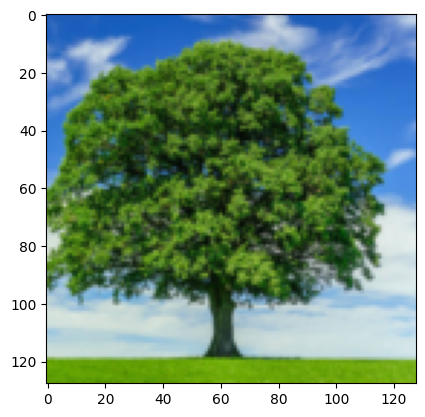

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch_tree[0].permute([1, 2, 0]) / 2 + 0.5)

## test

In [ ]:
cond_eeg = model.encode(batch_eeg.to(device))
xT_tree = model.encode_stochastic(batch_eeg.to(device), cond_eeg, T=250)

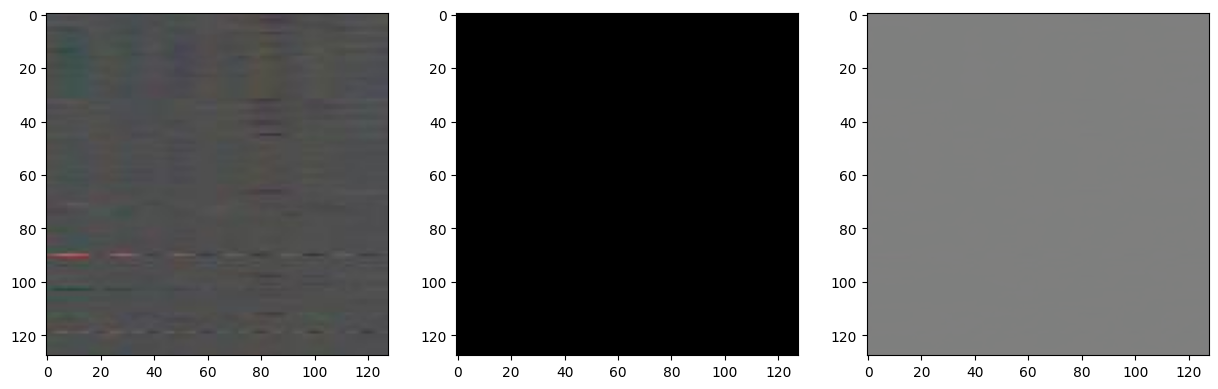

In [ ]:
pred = model.render(xT_tree, cond_eeg, T=20)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ori = (batch_eeg + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_tree[0].permute(1, 2, 0).cpu())
ax[2].imshow(pred[0].permute(1, 2, 0).cpu())

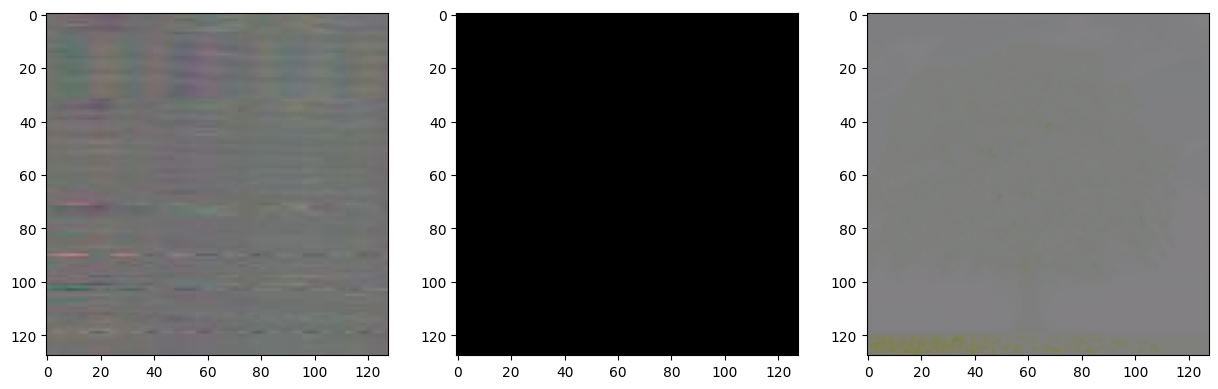

In [ ]:
cond_eeg2 = model.encode(batch_eeg2.to(device))
pred = model.render(xT_tree, cond_eeg2, T=20)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ori = (batch_eeg2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_tree[0].permute(1, 2, 0).cpu())
ax[2].imshow(pred[0].permute(1, 2, 0).cpu())